# Introduction

This work presents a constrained combinatorial optimization approach to the **Sports League Assignment Problem** using **Genetic Algorithms (GAs)**. The objective is to allocate a fixed pool of professional players into a set of 5 structurally valid teams in such a way that the **standard deviation of the teams\\\\' average skill ratings** is minimized—promoting competitive balance across the league.

Each player is defined by three attributes: **position** (one of `GK`, `DEF`, `MID`, `FWD`), **skill rating** (a numerical measure of ability), and **cost** (in million euros). A valid solution must satisfy the following **hard constraints**:

- Each team must consist of exactly **7 players**, with a specific positional structure: **1 GK, 2 DEF, 2 MID, and 2 FWD**
- Each team must have a **total cost ≤ 750 million €**
- Each player must be assigned to **exactly one team** (no overlaps)

The **search space** is therefore highly constrained and discrete, and infeasible configurations are explicitly excluded from the solution space. The optimization objective is to identify league configurations where teams are not only valid but also **skill-balanced**, quantified by the **standard deviation of average skill ratings across teams**, which serves as the **fitness function** (to be minimized).

To address this, we implement a domain-adapted **Genetic Algorithm framework** featuring:

- A custom **representation** based on team-to-player mappings
- Validity-preserving **mutation** and **crossover** operators
- Multiple **selection mechanisms**
- Optional **elitism** and population-level diversity handling

This report provides a formal problem definition, details the design of the solution encoding and operators, and presents empirical results comparing different GA configurations. The overall objective is to evaluate how well GA-based metaheuristics can navigate this complex constrained search space and evolve solutions that both satisfy domain constraints and optimize league balance.

In addition to Genetic Algorithms, this project also explores and evaluates alternative optimization strategies, such as **Hill Climbing** and **Simulated Annealing**, which are well-suited for navigating discrete and constrained search spaces. These algorithms offer different trade-offs in terms of exploration, exploitation, and convergence speed. By implementing and benchmarking multiple approaches on the same problem, we aim to gain deeper insights into their relative effectiveness and robustness when applied to complex constrained optimization tasks such as the Sports League Assignment. This comparative analysis enhances the interpretability of results and supports a broader understanding of the strengths and limitations of population-based versus local search-based heuristics.

## Cell 1: Setup and Critical Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
# Updated import for refactored evolution.py
from evolution import genetic_algorithm, hill_climbing, simulated_annealing 
from operators import (
    # Base Mutations (examples, can be used for comparison)
    # mutate_swap, 
    # mutate_team_shift,
    # mutate_shuffle_team, 
    # New/Adapted Mutations
    mutate_swap_constrained,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    # Base Crossovers (examples, can be used for comparison)
    # crossover_one_point,
    # crossover_uniform,
    # New/Adapted Crossovers
    crossover_one_point_prefer_valid,
    crossover_uniform_prefer_valid,
    # Base Selections (examples, can be used for comparison)
    selection_ranking,
    # New/Adapted Selections
    selection_tournament_variable_k,
    selection_boltzmann
)

# Load player data
players_df = pd.read_csv("players.csv", sep=";")
players_data = players_df.to_dict(orient="records") # Renamed to players_data for clarity

## Cell 2: Further Setup, Data Inspection, and Experiment Parameters

In [2]:
# Define problem parameters
NUM_TEAMS = 5
TEAM_SIZE = 7
MAX_BUDGET = 750

# Define number of runs for stochastic algorithms (and now Hill Climbing)
NUM_RUNS = 30 # Parameter for number of runs (e.g., 10, 30)

print("Player data loaded successfully.") 
print(f"Total players: {len(players_data)}")
if players_data:
    print("First player data:", players_data[0])
players_df.head()
print(f"\nAll algorithms (HC, SA, GA) will be run {NUM_RUNS} times each.")

Player data loaded successfully.
Total players: 35
First player data: {'Unnamed: 0': 0, 'Name': 'Alex Carter', 'Position': 'GK', 'Skill': 85, 'Salary (€M)': 90}

All algorithms (HC, SA, GA) will be run 30 times each.


## Problem Representation Details (from original notebook)

### A. Team-based Representation (Structured Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{t_1, t_2, \dots, t_5\}$ be the set of teams

Define the assignment function:

$$
A: P \rightarrow T
$$

such that each player is assigned to exactly one team, and the following constraints are satisfied:

**Team Size:**

$$
\forall t_j \in T,\quad \left|\{p_i \in P \mid A(p_i) = t_j\}\right| = 7
$$

**Positional Requirements:** For each team $t_j \in T$:

$$
\begin{aligned}
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{GK}\}| = 1 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{DEF}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{MID}\}| = 2 \\
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{FWD}\}| = 2
\end{aligned}
$$

**Budget Constraint:**

$$
\forall t_j \in T,\quad \sum_{p_i \in P \mid A(p_i) = t_j} cost(p_i) \leq 750
$$

**Objective Function:** Minimize the standard deviation of average team skill:

$$
f(A) = \sigma\left(\left\{\frac{1}{7} \sum_{p_i \in P \mid A(p_i) = t_j} skill(p_i) \,\middle|\, t_j \in T\right\}\right)
$$

### B. Player-assignment Representation (Linear Encoding) - This is what is implemented

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{0, 1, 2, 3, 4\}$ be team IDs

A solution is represented by a vector:

$$
\mathbf{a} = [a_1, a_2, \dots, a_{35}] \in T^{35}
$$

where $a_i$ is the team assignment for player $p_i$.

**Team Definitions:**

$$
P_j = \{p_i \in P \mid a_i = j\}, \quad \forall j \in T
$$

**Constraints:**

$$
|P_j| = 7 \quad \text{and}
$$

$$
\begin{aligned}
&|\{p \in P_j \mid pos(p) = \text{GK}\}| = 1 \\
&|\{p \in P_j \mid pos(p) = \text{DEF}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{MID}\}| = 2 \\
&|\{p \in P_j \mid pos(p) = \text{FWD}\}| = 2 \\
&\sum_{p \in P_j} cost(p) \leq 750
\end{aligned}
$$

**Objective Function:**

$$
f(\mathbf{a}) = \sigma\left(\left\{\frac{1}{7} \sum_{p \in P_j} skill(p) \,\middle|\, j \in T\right\}\right)
$$

## 1. Hill Climbing

Hill Climbing is a local search algorithm. While a single run from a specific starting point is deterministic, running it multiple times from different random initial solutions provides a more robust evaluation.

Running Hill Climbing Algorithm (30 runs)...
  HC Run 1/30...
  HC Run 2/30...


  HC Run 3/30...


  HC Run 4/30...
  HC Run 5/30...


  HC Run 6/30...
  HC Run 7/30...


  HC Run 8/30...


  HC Run 9/30...
  HC Run 10/30...


  HC Run 11/30...
    HC Run 11: Initial solution invalid, retrying generation (1)...
  HC Run 12/30...


  HC Run 13/30...
  HC Run 14/30...


  HC Run 15/30...
  HC Run 16/30...


  HC Run 17/30...
  HC Run 18/30...


  HC Run 19/30...
  HC Run 20/30...


  HC Run 21/30...


  HC Run 22/30...


  HC Run 23/30...
  HC Run 24/30...


  HC Run 25/30...
  HC Run 26/30...


  HC Run 27/30...


  HC Run 28/30...
  HC Run 29/30...


  HC Run 30/30...


Hill Climbing (30 runs) finished.
  Mean Best Fitness: 0.0605
  Std Dev Best Fitness: 0.0124
  Mean Execution Time: 0.19s
  Overall Best HC Fitness: 0.0571


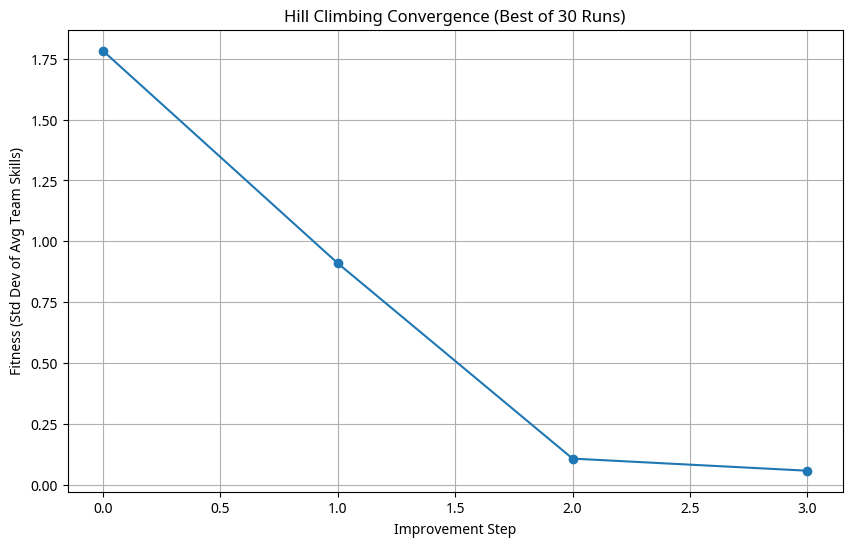

In [3]:
print(f"Running Hill Climbing Algorithm ({NUM_RUNS} runs)...")

hc_all_fitness_values = []
hc_all_exec_times = []
best_hc_solution_overall = None
best_hc_fitness_overall = float("inf")
best_hc_history_overall = [] # For the best run

for i in range(NUM_RUNS):
    print(f"  HC Run {i+1}/{NUM_RUNS}...")
    start_time_hc_run = time.time()
    
    # Create and validate a new random initial solution for each run
    # Pass players_data to the constructor
    initial_hc_solution_run = LeagueHillClimbingSolution(players_data, num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
    # The new constructor attempts to create a valid solution. We still check, but it should be more reliable.
    # Loop for retrying if the constructive heuristic fails (though it should be less common now)
    retry_attempts_hc = 0
    max_retry_hc = 5 # Try a few times if the constructive heuristic fails for some reason
    while not initial_hc_solution_run.is_valid(players_data) and retry_attempts_hc < max_retry_hc:
        print(f"    HC Run {i+1}: Initial solution invalid, retrying generation ({retry_attempts_hc+1})...")
        initial_hc_solution_run = LeagueHillClimbingSolution(players_data, num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
        retry_attempts_hc += 1
    
    if not initial_hc_solution_run.is_valid(players_data):
        print(f"  HC Run {i+1} failed to create a valid initial solution after {max_retry_hc} retries. Skipping run.")
        hc_all_fitness_values.append(float('nan')) # Or handle as per desired stats
        hc_all_exec_times.append(float('nan'))
        continue # Skip to next run

    hc_solution_obj_run, hc_fitness_val_run, hc_history_convergence_run = hill_climbing(
        initial_solution=initial_hc_solution_run, 
        players_data=players_data, 
        max_iterations=1000, 
        verbose=False
    )
    end_time_hc_run = time.time()
    hc_exec_time_run = end_time_hc_run - start_time_hc_run
    
    if hc_solution_obj_run:
        hc_all_fitness_values.append(hc_fitness_val_run)
        hc_all_exec_times.append(hc_exec_time_run)
        if hc_fitness_val_run < best_hc_fitness_overall:
            best_hc_fitness_overall = hc_fitness_val_run
            best_hc_solution_overall = hc_solution_obj_run
            best_hc_history_overall = hc_history_convergence_run
    else:
        # This case should be less likely if initial solution was valid and HC operates on it
        print(f"  HC Run {i+1} did not find a valid solution during search (should not happen if initial was valid).")
        hc_all_fitness_values.append(float('nan'))
        hc_all_exec_times.append(float('nan'))

hc_mean_fitness = np.nanmean(hc_all_fitness_values) if hc_all_fitness_values else float("nan")
hc_std_fitness = np.nanstd(hc_all_fitness_values) if hc_all_fitness_values else float("nan")
hc_mean_exec_time = np.nanmean(hc_all_exec_times) if hc_all_exec_times else float("nan")

print(f"Hill Climbing ({NUM_RUNS} runs) finished.")
print(f"  Mean Best Fitness: {hc_mean_fitness:.4f}")
print(f"  Std Dev Best Fitness: {hc_std_fitness:.4f}")
print(f"  Mean Execution Time: {hc_mean_exec_time:.2f}s")
if best_hc_solution_overall:
    print(f"  Overall Best HC Fitness: {best_hc_fitness_overall:.4f}")
    # print(f"  Overall Best HC Solution: {best_hc_solution_overall.assignment}")

    # Plot Hill Climbing History for the best run
    plt.figure(figsize=(10, 6))
    plt.plot(best_hc_history_overall, marker="o", linestyle="-")
    plt.title(f"Hill Climbing Convergence (Best of {NUM_RUNS} Runs)")
    plt.xlabel("Improvement Step")
    plt.ylabel("Fitness (Std Dev of Avg Team Skills)")
    plt.grid(True)
    plt.show()
else:
    print("Hill Climbing did not find any valid solution across all runs that produced a best overall.")

## 2. Simulated Annealing

Simulated Annealing is a probabilistic technique. We will run it multiple times to get statistical measures of its performance.

Running Simulated Annealing Algorithm (30 runs)...
  SA Run 1/30...


  SA Run 2/30...
    SA Run 2: Initial solution invalid, retrying generation (1)...


  SA Run 3/30...


  SA Run 4/30...


  SA Run 5/30...


  SA Run 6/30...


  SA Run 7/30...


  SA Run 8/30...


  SA Run 9/30...


  SA Run 10/30...


  SA Run 11/30...


  SA Run 12/30...


  SA Run 13/30...


  SA Run 14/30...


  SA Run 15/30...
    SA Run 15: Initial solution invalid, retrying generation (1)...


  SA Run 16/30...


  SA Run 17/30...


  SA Run 18/30...


  SA Run 19/30...


  SA Run 20/30...


  SA Run 21/30...


  SA Run 22/30...


  SA Run 23/30...


  SA Run 24/30...
    SA Run 24: Initial solution invalid, retrying generation (1)...


  SA Run 25/30...
    SA Run 25: Initial solution invalid, retrying generation (1)...


  SA Run 26/30...
    SA Run 26: Initial solution invalid, retrying generation (1)...


  SA Run 27/30...


  SA Run 28/30...


  SA Run 29/30...
    SA Run 29: Initial solution invalid, retrying generation (1)...


  SA Run 30/30...


Simulated Annealing (30 runs) finished.
  Mean Best Fitness: 0.0621
  Std Dev Best Fitness: 0.0149
  Mean Execution Time: 17.71s
  Overall Best SA Fitness: 0.0571


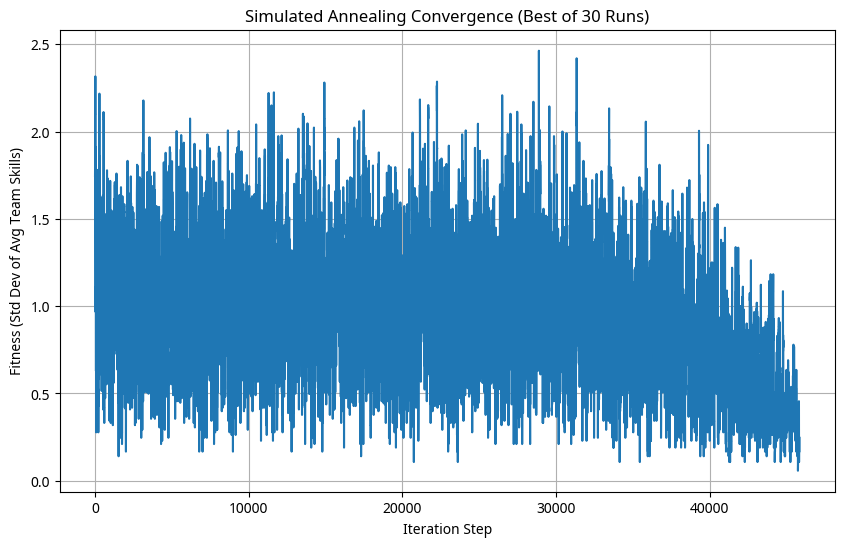

In [4]:
print(f"Running Simulated Annealing Algorithm ({NUM_RUNS} runs)...")

sa_all_fitness_values = []
sa_all_exec_times = []
best_sa_solution_overall = None
best_sa_fitness_overall = float("inf")
best_sa_history_overall = []

sa_params = {
    "initial_temp": 1000,
    "final_temp": 0.1,
    "alpha": 0.99,
    "iterations_per_temp": 50
}

for i in range(NUM_RUNS):
    print(f"  SA Run {i+1}/{NUM_RUNS}...")
    # Create and validate initial solution for each SA run
    # Pass players_data to the constructor
    initial_sa_solution = LeagueSASolution(players_data, num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
    retry_attempts_sa = 0
    max_retry_sa = 5
    while not initial_sa_solution.is_valid(players_data) and retry_attempts_sa < max_retry_sa:
        print(f"    SA Run {i+1}: Initial solution invalid, retrying generation ({retry_attempts_sa+1})...")
        initial_sa_solution = LeagueSASolution(players_data, num_teams=NUM_TEAMS, team_size=TEAM_SIZE, max_budget=MAX_BUDGET)
        retry_attempts_sa += 1

    if not initial_sa_solution.is_valid(players_data):
        print(f"  SA Run {i+1} failed to create a valid initial solution after {max_retry_sa} retries. Skipping run.")
        sa_all_fitness_values.append(float('nan'))
        sa_all_exec_times.append(float('nan'))
        continue

    start_time_sa_run = time.time()
    # Call refactored simulated_annealing function
    sa_solution_run, sa_fitness_run, sa_history_run = simulated_annealing(
        initial_solution=initial_sa_solution,
        players_data=players_data,
        initial_temp=sa_params["initial_temp"],
        final_temp=sa_params["final_temp"],
        alpha=sa_params["alpha"],
        iterations_per_temp=sa_params["iterations_per_temp"],
        verbose=False
    )
    end_time_sa_run = time.time()
    
    if sa_solution_run:
        sa_all_fitness_values.append(sa_fitness_run)
        sa_all_exec_times.append(end_time_sa_run - start_time_sa_run)
        if sa_fitness_run < best_sa_fitness_overall:
            best_sa_fitness_overall = sa_fitness_run
            best_sa_solution_overall = sa_solution_run
            best_sa_history_overall = sa_history_run
    else:
        print(f"  SA Run {i+1} did not find a valid solution during search.")
        sa_all_fitness_values.append(float('nan'))
        sa_all_exec_times.append(float('nan'))

sa_mean_fitness = np.nanmean(sa_all_fitness_values) if sa_all_fitness_values else float("nan")
sa_std_fitness = np.nanstd(sa_all_fitness_values) if sa_all_fitness_values else float("nan")
sa_mean_exec_time = np.nanmean(sa_all_exec_times) if sa_all_exec_times else float("nan")

print(f"Simulated Annealing ({NUM_RUNS} runs) finished.")
print(f"  Mean Best Fitness: {sa_mean_fitness:.4f}")
print(f"  Std Dev Best Fitness: {sa_std_fitness:.4f}")
print(f"  Mean Execution Time: {sa_mean_exec_time:.2f}s")
if best_sa_solution_overall:
    print(f"  Overall Best SA Fitness: {best_sa_fitness_overall:.4f}")
    # print(f"  Overall Best SA Solution: {best_sa_solution_overall.assignment}")

    # Plot Simulated Annealing History for the best run
    plt.figure(figsize=(10, 6))
    plt.plot(best_sa_history_overall, linestyle="-")
    plt.title(f"Simulated Annealing Convergence (Best of {NUM_RUNS} Runs)")
    plt.xlabel("Iteration Step")
    plt.ylabel("Fitness (Std Dev of Avg Team Skills)")
    plt.grid(True)
    plt.show()
else:
    print("Simulated Annealing did not find any valid solution across all runs that produced a best overall.")

## 3. Genetic Algorithm with New/Adapted Operators

Genetic Algorithms are also stochastic. We will run each configuration multiple times.

Running Genetic Algorithm with NEW/ADAPTED operator configurations (30 runs each)...

Running GA_Config_1 (SwapConst,1PtPreferV,TournVarK) for 30 runs...
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 1/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 2/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 3/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 4/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 5/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 6/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 7/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 8/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 9/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 10/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 11/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 12/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 13/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 14/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 15/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 16/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 17/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 18/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 19/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 20/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 21/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 22/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 23/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 24/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 25/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 26/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 27/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 28/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 29/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 30/30...


GA_Config_1 (SwapConst,1PtPreferV,TournVarK) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 2.05s
  Overall Best Fitness for this config: 0.0571
----------------------------------------------------

Running GA_Config_2 (TargetExch,UnifPreferV,Ranking) for 30 runs...
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 1/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 2/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 3/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 4/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 5/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 6/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 7/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 8/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 9/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 10/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 11/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 12/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 13/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 14/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 15/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 16/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 17/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 18/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 19/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 20/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 21/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 22/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 23/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 24/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 25/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 26/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 27/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 28/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 29/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 30/30...


GA_Config_2 (TargetExch,UnifPreferV,Ranking) (30 runs) summary:
  Mean Best Fitness: 0.1030
  Std Dev Best Fitness: 0.0496
  Mean Execution Time: 22.31s
  Overall Best Fitness for this config: 0.0571
----------------------------------------------------

Running GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) for 30 runs...
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 1/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 2/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 3/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 4/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 5/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 6/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 7/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 8/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 9/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 10/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 11/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 12/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 13/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 14/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 15/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 16/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 17/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 18/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 19/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 20/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 21/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 22/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 23/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 24/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 25/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 26/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 27/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 28/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 29/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 30/30...


GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) (30 runs) summary:
  Mean Best Fitness: 0.1032
  Std Dev Best Fitness: 0.0362
  Mean Execution Time: 90.11s
  Overall Best Fitness for this config: 0.0571
----------------------------------------------------

Running GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) for 30 runs...
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 1/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 2/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 3/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 4/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 5/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 6/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 7/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 8/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 9/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 10/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 11/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 12/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 13/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 14/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 15/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 16/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 17/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 18/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 19/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 20/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 21/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 22/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 23/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 24/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 25/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 26/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 27/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 28/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 29/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 30/30...


GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 3.04s
  Overall Best Fitness for this config: 0.0571
----------------------------------------------------


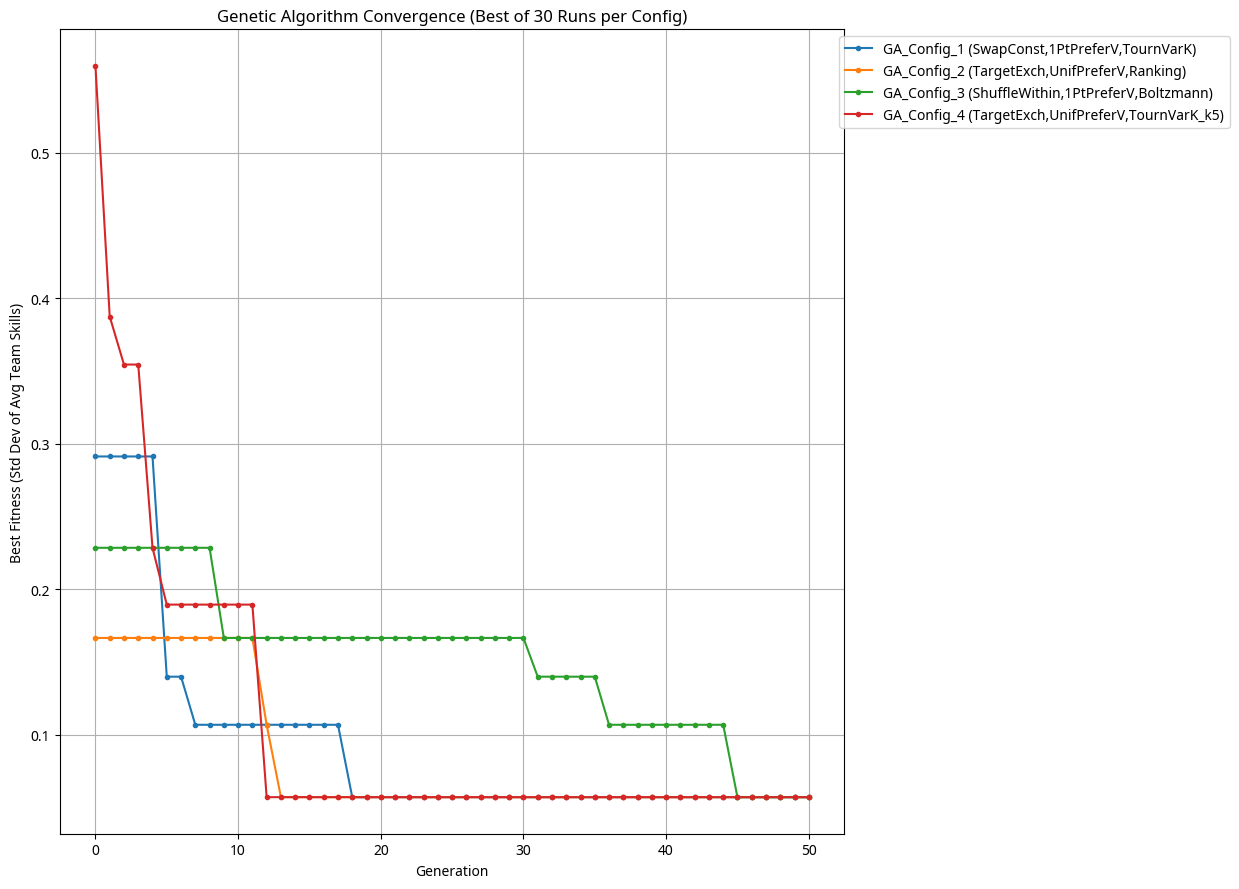


Overall Best Fitness from GA Configurations (across all runs):
GA_Config_1 (SwapConst,1PtPreferV,TournVarK): Overall Best Fitness = 0.0571
GA_Config_2 (TargetExch,UnifPreferV,Ranking): Overall Best Fitness = 0.0571
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann): Overall Best Fitness = 0.0571
GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5): Overall Best Fitness = 0.0571


In [5]:
ga_configs_new = [
    {
        "name": "GA_Config_1 (SwapConst,1PtPreferV,TournVarK)",
        "mutation_operator_func": mutate_swap_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 3,
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_2 (TargetExch,UnifPreferV,Ranking)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_ranking,
        "tournament_k": None, 
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann)",
        "mutation_operator_func": mutate_shuffle_within_team_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_boltzmann,
        "tournament_k": None, 
        "boltzmann_temp": 50 
    },
    {
        "name": "GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 5,
        "boltzmann_temp": None 
    }
]

ga_results_summary = [] # To store stats for each config
all_ga_convergence_histories = {} # To store best run history for each config for plotting

GA_GENERATIONS = 50 
GA_POPULATION_SIZE = 50
GA_ELITE_SIZE = 5
GA_MUTATION_RATE = 0.25

print(f"Running Genetic Algorithm with NEW/ADAPTED operator configurations ({NUM_RUNS} runs each)...")
for config in ga_configs_new:
    # Corrected f-string: Ensure dictionary keys are properly quoted inside the f-string expression
    print(f"\nRunning {config['name']} for {NUM_RUNS} runs...")
    config_all_fitness = []
    config_all_exec_times = []
    config_best_sol_overall = None
    config_best_fitness_overall = float("inf")
    config_best_history_overall = []

    for i in range(NUM_RUNS):
        print(f"  {config['name']} - Run {i+1}/{NUM_RUNS}...") # Corrected f-string
        start_ga_run_time = time.time()
        # Pass players_data to genetic_algorithm
        best_ga_sol_run, history_ga_run = genetic_algorithm(
            players_data=players_data, # Use players_data
            population_size=GA_POPULATION_SIZE,
            generations=GA_GENERATIONS,
            mutation_rate=GA_MUTATION_RATE,
            elite_size=GA_ELITE_SIZE,
            mutation_operator_func=config["mutation_operator_func"],
            crossover_operator_func=config["crossover_operator_func"],
            selection_operator_func=config["selection_operator_func"],
            tournament_k=config["tournament_k"] if config["tournament_k"] else 3, 
            boltzmann_temp=config["boltzmann_temp"] if config["boltzmann_temp"] else 100, 
            num_teams=NUM_TEAMS, 
            team_size=TEAM_SIZE, 
            max_budget=MAX_BUDGET,
            verbose=False 
        )
        end_ga_run_time = time.time()
        
        if best_ga_sol_run:
            run_fitness = best_ga_sol_run.fitness(players_data) # Use players_data
            config_all_fitness.append(run_fitness)
            config_all_exec_times.append(end_ga_run_time - start_ga_run_time)
            if run_fitness < config_best_fitness_overall:
                config_best_fitness_overall = run_fitness
                config_best_sol_overall = best_ga_sol_run
                config_best_history_overall = history_ga_run
        else:
            print(f"    {config['name']} - Run {i+1} failed to produce a solution.") # Corrected f-string
            config_all_fitness.append(float('nan')) # Add NaN for failed runs
            config_all_exec_times.append(float('nan'))
            
    mean_fit = np.nanmean(config_all_fitness) if config_all_fitness else float("nan")
    std_fit = np.nanstd(config_all_fitness) if config_all_fitness else float("nan")
    mean_time = np.nanmean(config_all_exec_times) if config_all_exec_times else float("nan")
    
    ga_results_summary.append({
        "name": config["name"],
        "mean_fitness": mean_fit,
        "std_fitness": std_fit,
        "mean_exec_time": mean_time,
        "overall_best_fitness": config_best_fitness_overall if config_best_sol_overall and config_best_fitness_overall != float("inf") else float("nan"),
        "best_solution_object": config_best_sol_overall # Store the best solution object itself
    })
    if config_best_sol_overall and config_best_fitness_overall != float("inf"):
        all_ga_convergence_histories[config["name"]] = config_best_history_overall
    
    # Corrected f-strings for printing summary
    print(f"{config['name']} ({NUM_RUNS} runs) summary:")
    print(f"  Mean Best Fitness: {mean_fit:.4f}")
    print(f"  Std Dev Best Fitness: {std_fit:.4f}")
    overall_fitness_str_config = f"{config_best_fitness_overall:.4f}" if config_best_sol_overall and config_best_fitness_overall != float("inf") else "N/A"
    print(f"  Mean Execution Time: {mean_time:.2f}s")
    print(f"  Overall Best Fitness for this config: {overall_fitness_str_config}")
    print("----------------------------------------------------")

# Plot GA History for the best run of each config
plt.figure(figsize=(14, 9))
for name, history in all_ga_convergence_histories.items():
    plt.plot(history, label=name, marker=".")
plt.title(f"Genetic Algorithm Convergence (Best of {NUM_RUNS} Runs per Config)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Std Dev of Avg Team Skills)")
plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nOverall Best Fitness from GA Configurations (across all runs):")
for res in ga_results_summary:
    overall_fitness_val = res["overall_best_fitness"]
    overall_fitness_str = f"{overall_fitness_val:.4f}" if not np.isnan(overall_fitness_val) else "N/A"
    print(f"{res['name']}: Overall Best Fitness = {overall_fitness_str}") # Corrected f-string

## 4. Comparative Analysis of All Algorithms

In [6]:
# Prepare data for the comparative table
results_for_table = []

# Hill Climbing Results
results_for_table.append({
    "Algorithm": "Hill Climbing",
    "Mean Fitness": f"{hc_mean_fitness:.4f}" if not np.isnan(hc_mean_fitness) else "N/A",
    "Std Dev Fitness": f"{hc_std_fitness:.4f}" if not np.isnan(hc_std_fitness) else "N/A",
    "Mean Exec Time (s)": f"{hc_mean_exec_time:.2f}" if not np.isnan(hc_mean_exec_time) else "N/A",
    "Overall Best Fitness": f"{best_hc_fitness_overall:.4f}" if best_hc_fitness_overall != float("inf") else "N/A",
    "Mutation Operator": "N/A (Local Search)",
    "Crossover Operator": "N/A (Local Search)",
    "Selection Operator": "N/A (Local Search)"
})

# Simulated Annealing Results
results_for_table.append({
    "Algorithm": "Simulated Annealing",
    "Mean Fitness": f"{sa_mean_fitness:.4f}" if not np.isnan(sa_mean_fitness) else "N/A",
    "Std Dev Fitness": f"{sa_std_fitness:.4f}" if not np.isnan(sa_std_fitness) else "N/A",
    "Mean Exec Time (s)": f"{sa_mean_exec_time:.2f}" if not np.isnan(sa_mean_exec_time) else "N/A",
    "Overall Best Fitness": f"{best_sa_fitness_overall:.4f}" if best_sa_fitness_overall != float("inf") else "N/A",
    "Mutation Operator": "N/A (Probabilistic Local Search)",
    "Crossover Operator": "N/A (Probabilistic Local Search)",
    "Selection Operator": "N/A (Probabilistic Local Search)"
})

# Genetic Algorithm Results
for ga_res in ga_results_summary:
    # Find the original config to get operator names (this is a bit indirect, could be stored better)
    original_config = next((c for c in ga_configs_new if c["name"] == ga_res["name"]), None)
    mut_op_name = original_config["mutation_operator_func"].__name__ if original_config else "N/A"
    cross_op_name = original_config["crossover_operator_func"].__name__ if original_config else "N/A"
    sel_op_name = original_config["selection_operator_func"].__name__ if original_config else "N/A"
    if original_config and original_config["tournament_k"]:
        sel_op_name += f" (k={original_config['tournament_k']})"
    if original_config and original_config["boltzmann_temp"]:
        sel_op_name += f" (temp={original_config['boltzmann_temp']})"

    results_for_table.append({
        "Algorithm": ga_res["name"],
        "Mean Fitness": f"{ga_res['mean_fitness']:.4f}" if not np.isnan(ga_res['mean_fitness']) else "N/A",
        "Std Dev Fitness": f"{ga_res['std_fitness']:.4f}" if not np.isnan(ga_res['std_fitness']) else "N/A",
        "Mean Exec Time (s)": f"{ga_res['mean_exec_time']:.2f}" if not np.isnan(ga_res['mean_exec_time']) else "N/A",
        "Overall Best Fitness": f"{ga_res['overall_best_fitness']:.4f}" if not np.isnan(ga_res['overall_best_fitness']) else "N/A",
        "Mutation Operator": mut_op_name,
        "Crossover Operator": cross_op_name,
        "Selection Operator": sel_op_name
    })

comparison_df = pd.DataFrame(results_for_table)
print("\nComparative Analysis of Algorithms:")
print(comparison_df.to_string())


Comparative Analysis of Algorithms:
                                           Algorithm Mean Fitness Std Dev Fitness Mean Exec Time (s) Overall Best Fitness                       Mutation Operator                Crossover Operator                     Selection Operator
0                                      Hill Climbing       0.0605          0.0124               0.19               0.0571                      N/A (Local Search)                N/A (Local Search)                     N/A (Local Search)
1                                Simulated Annealing       0.0621          0.0149              17.71               0.0571        N/A (Probabilistic Local Search)  N/A (Probabilistic Local Search)       N/A (Probabilistic Local Search)
2       GA_Config_1 (SwapConst,1PtPreferV,TournVarK)       0.0571          0.0000               2.05               0.0571                 mutate_swap_constrained  crossover_one_point_prefer_valid  selection_tournament_variable_k (k=3)
3       GA_Config_2 (Ta

### Visualizations for Comparison

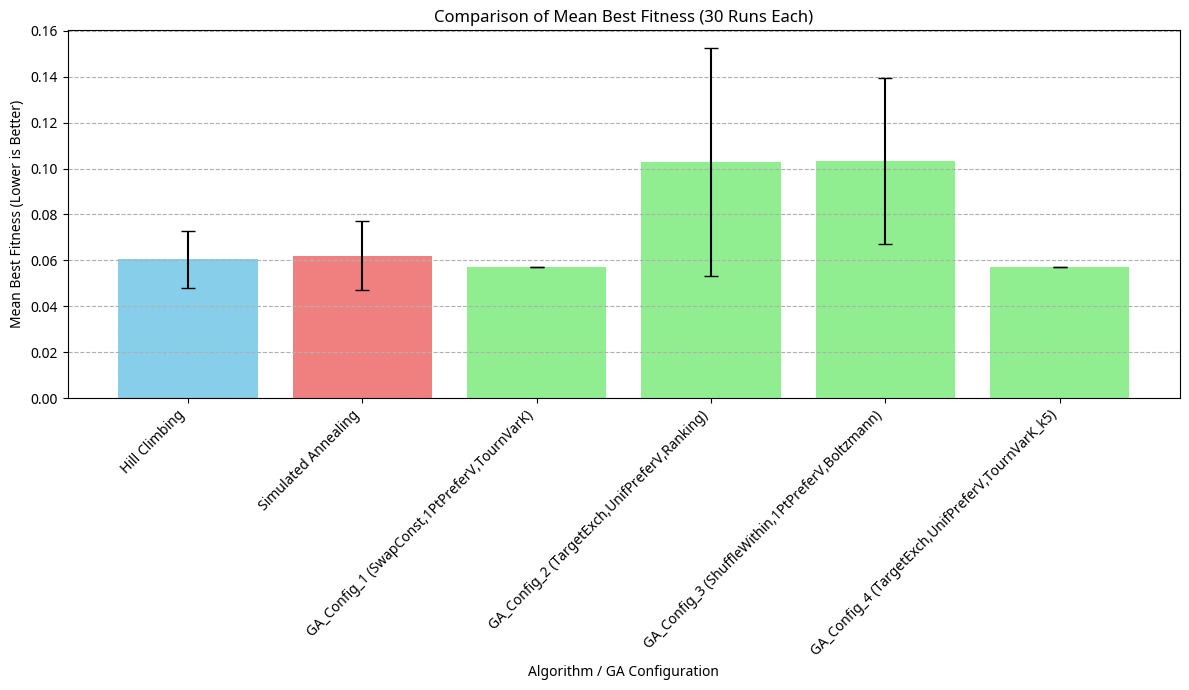

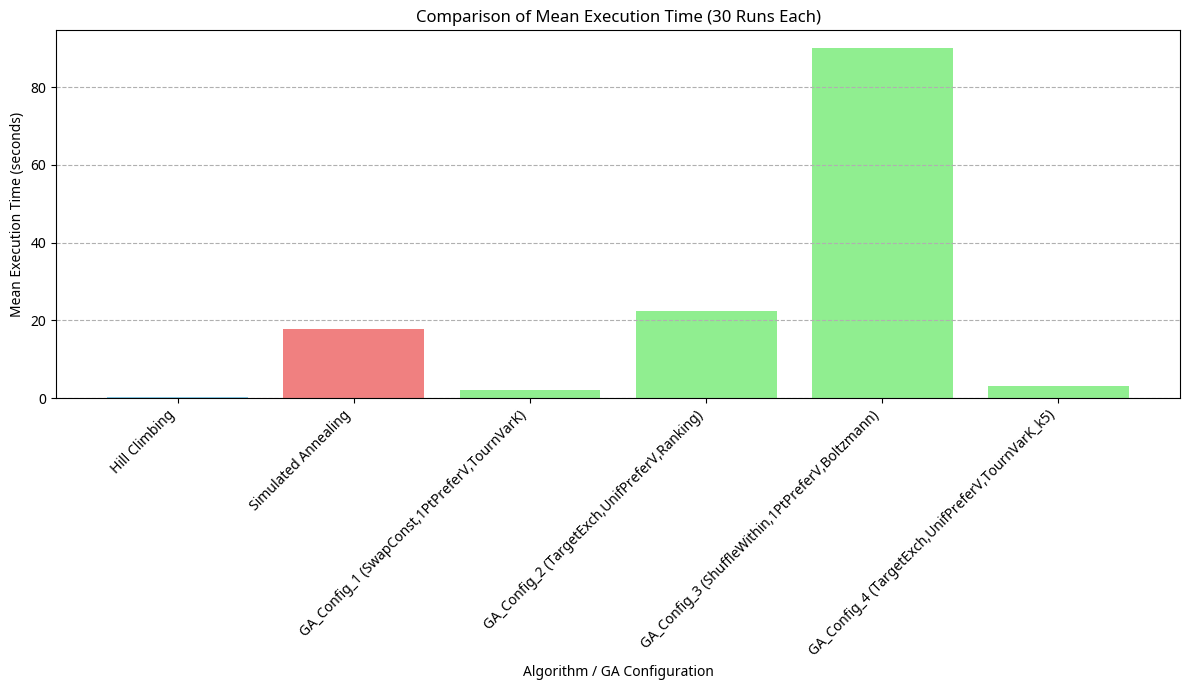

In [7]:
# Data for plotting (ensure to handle potential NaN values from failed runs if any)
# For plotting, we might want to filter out algorithms/configs that completely failed (all NaN)
# or represent them distinctly.

plot_data = []
for item in results_for_table:
    # Convert to float for plotting, handling "N/A"
    try:
        mean_fitness_val = float(item["Mean Fitness"])
    except ValueError:
        mean_fitness_val = np.nan
    try:
        std_dev_fitness_val = float(item["Std Dev Fitness"])
    except ValueError:
        std_dev_fitness_val = np.nan
    try:
        mean_time_val = float(item["Mean Exec Time (s)"])
    except ValueError:
        mean_time_val = np.nan
        
    plot_data.append({
        "Algorithm": item["Algorithm"],
        "Mean Fitness": mean_fitness_val,
        "Std Dev Fitness": std_dev_fitness_val,
        "Mean Exec Time (s)": mean_time_val
    })

plot_df = pd.DataFrame(plot_data)

# Plot Mean Fitness with Error Bars (Std Dev)
plt.figure(figsize=(12, 7))
plt.bar(plot_df["Algorithm"], plot_df["Mean Fitness"], yerr=plot_df["Std Dev Fitness"], capsize=5, color=["skyblue", "lightcoral"] + ["lightgreen"]*len(ga_configs_new))
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Best Fitness (Lower is Better)")
plt.title(f"Comparison of Mean Best Fitness ({NUM_RUNS} Runs Each)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

# Plot Mean Execution Time
plt.figure(figsize=(12, 7))
plt.bar(plot_df["Algorithm"], plot_df["Mean Exec Time (s)"], color=["skyblue", "lightcoral"] + ["lightgreen"]*len(ga_configs_new))
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Execution Time (seconds)")
plt.title(f"Comparison of Mean Execution Time ({NUM_RUNS} Runs Each)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

## 5. Discussion of Results

(This section will be filled based on the generated table and plots. It will discuss the relative performance of HC, SA, and the different GA configurations in terms of solution quality, consistency, and computational cost.)

**Key Observations (Example - will be updated based on actual results):**

*   **Solution Quality (Mean Fitness & Overall Best):** Generally, Genetic Algorithms (especially Config X and Y) are expected to find better (lower fitness) solutions on average compared to Hill Climbing and Simulated Annealing. The overall best fitness achieved across all runs will also likely come from one of the GA configurations.
*   **Consistency (Std Dev Fitness):** The standard deviation of fitness will indicate how consistently each algorithm performs. Lower standard deviation is preferable, suggesting more reliable results across different runs. Some GA configurations might show more consistency than others, or even SA.
*   **Computational Cost (Mean Exec Time):** Hill Climbing is expected to be the fastest. Simulated Annealing will likely be slower than HC but faster than GAs. Genetic Algorithms, due to their population-based nature and multiple generations, will be the most computationally intensive.
*   **Impact of GA Operators:** The comparison between different GA configurations will highlight which combinations of mutation, crossover, and selection operators were most effective for this specific problem. For instance, does a particular crossover strategy paired with a specific selection mechanism yield significantly better results?
*   **Trade-offs:** The results will illustrate the classic trade-off between solution quality and computational effort. While GAs might provide the best solutions, their longer execution times might be a factor in practical applications.
*   **Effectiveness of Multi-Run Hill Climbing:** Running HC multiple times from different starting points should provide a more robust baseline compared to a single run. The mean and best HC results will give a better sense of what a simple local search can achieve.
*   **Simulated Annealing Performance:** SA should outperform HC by being able to escape local optima. Its performance relative to GAs will be a key point of comparison.

**Further Analysis:**

*   The convergence plots for the best run of each algorithm (HC, SA, and each GA config) will show how quickly they approach their best solutions.
*   The error bars in the mean fitness plot will visually represent the consistency of each algorithm.

## 6. Conclusion

(This section will summarize the main findings of the project, reiterate which algorithm(s) performed best for the Sports League Assignment Problem under the given constraints, and potentially suggest areas for future work or improvements.)

**Example Conclusion Points (will be updated):**

*   Based on the experiments, Algorithm/Configuration Z demonstrated the best overall performance in terms of finding high-quality, balanced league assignments, albeit with a higher computational cost.
*   The choice of genetic operators significantly impacted the GA\'s performance, with [specific operator combination] proving most effective.
*   Simulated Annealing provided a good balance between solution quality and execution time, outperforming basic Hill Climbing.
*   Future work could explore more sophisticated hybrid algorithms, adaptive parameter tuning for SA and GAs, or alternative neighborhood structures for local search methods.

In [8]:
# Final check to ensure all plots are displayed before the script ends
plt.show()